# Introduction

The ideal state space model is converted into a discrete $\delta$-domain state space model. A similarity transform is preformed on the model to convert it into a $\delta$ operator-based direct-form IIR filter ($\delta$DFIIt). The state variable amplitudes are maximized by scaling their dynamic range then converted to power of 2 division right shift operators. 

# $\Sigma\Delta$ Filter Architecture

This structure is very similar to the $\delta$ operator-based direct-form IIR filter ($\delta$DFIIt) presented in [A generalized direct-form delta operator-based IIR filter](https://ieeexplore.ieee.org/document/933811). The main difference is the discrete $\Sigma\Delta$ modulator after the filter output and before the feedback path. The input to the filter is also $\Sigma\Delta$ encoded. The $\Sigma\Delta$ filter and modulator can be constructed from just multiplexers, adders, registers, and bitshifts resulting much less circuit resource consumption than their fixed point counterparts. Having both a one bit feedforward and feedback path the allows the coefficient gains to be digital multiplexers rather than multipliers. The coefficients are driven between their positive and negative values. 

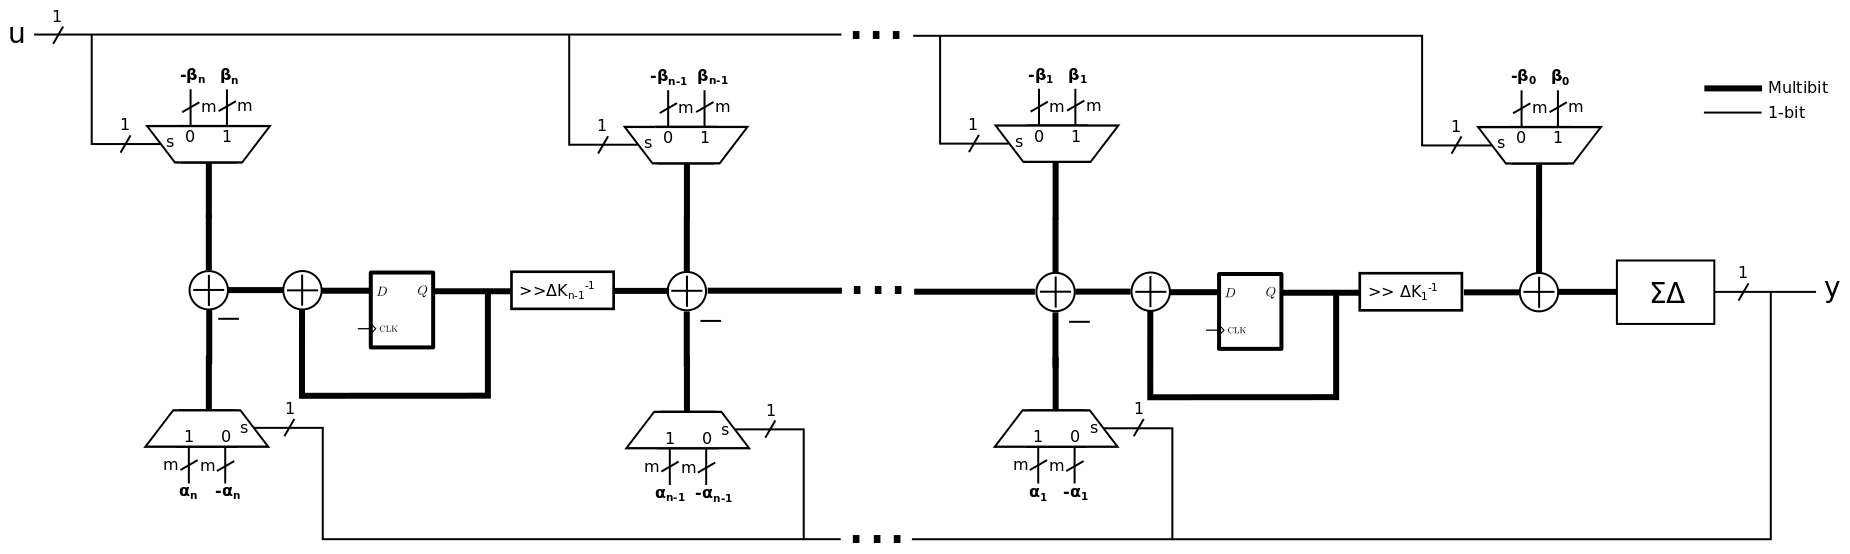

In [1]:
from IPython.display import Image
Image(filename='./Figures/IIR.png')

The filter node is the point in the circuit were the corresponding coefficient scalings are added to the bit-shifted output of the previous node and accumulated in a discrete integrator. The inverse of the $\delta$ operator is implemented via the discrete integrator and a bitshift. The scaled $\delta$ operator $\Delta\tilde{k}_{n-1}^{-1}$ gain occurs after the accumulator.

The multiplexer coefficient gains do not require any rounding or truncation. The bitstream is simply scaled by the coefficients and the multiplexer multibit outputs are the same size as the coefficients themselves. In conventional shift based filtering, high order sections of filters are not used due in part to the accumulation of coefficient round-off noise. The problem is exacerbated in shift operator based design while delta operator design are significantly more insensitive to coefficient round-off noise. Its possible to directly construct 8th order or higher $\Sigma\Delta$ filter without cascading. 

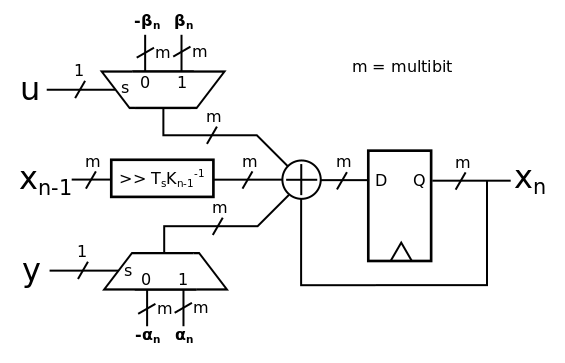

In [2]:
Image(filename='./Figures/filter_node_rtl.png')

In [3]:
# %load ./header.py
import numpy as np
from scipy import signal
from scipy import linalg
import control
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import Math, display, Latex, Markdown
import sys

if '../sdfpy' not in sys.path:
  sys.path.insert(0,'../sdfpy')

import sd_sim
import sdfpy as sdf

OSR = 256      # oversample ratio
fb = 22050     # nyquist
fs = OSR*2*fb  # sampling frequency
ts = 1/fs      # sampling period


In [4]:
%store -r
[A,B,C,D] = the_filter

In [5]:
display(Latex(f'$%s$' % sdf.print_ss_eq(A,B,C,D)))

<IPython.core.display.Latex object>

$H_{c}(s)$ = $D_{c} + C_{c} \left(Is - A_{c}\right)^{-1} B_{c}$

Here is the classic formulation of the ideal continuous state space transfer function

## Matrix Balancing
An important step in step in linear algebra computations is matrix balancing. This is the preprocessing of an ill conditioned matrix. The matrix is unbalanced when the L2 norm of the rows / columns are different by orders of magnitude. This leads to computations that are numerically unstable. 

[Matrix Balancing in Lp Norms](https://escholarship.org/uc/item/3847b5dr)

In [6]:
[A, T] = linalg.matrix_balance(A)
B = linalg.solve(T, B) 
C = C @ T
display(Latex(f'$%s$' % sdf.print_ss_eq(A,B,C,D)))

<IPython.core.display.Latex object>

$H_{c}(s)$ = $D_{c} + C_{c} \left(Is - A_{c}\right)^{-1} B_{c}$

This is how the the ideal continuous state space model looks after matrix balancing

In [7]:
OSR = 256      # oversample ratio
fb  = 22050    # nyquist
fs  = OSR*2*fb # sampling frequency
ts  = 1/fs     # sampling period
f   = np.logspace(0,np.log10(fb),2**10)

# State Space Model

- x and $\dot{x}$ are the state vector and the differential state vector respectively
- u and y are input vector and output vector respectively
- A is the system matrix
- B and C are the input and the output matrices
- D is the feed-forward matrix

Below is the continuous time representation

$\dot{x} = A_{c}x + B_{c}u$<br>
$y = C_{c}x + D_{c}u$

Which can also be represented in block matrix form

$\left[\begin{matrix}A & B\\C & D\end{matrix}\right]$ := $C \left(Is - A\right)^{-1} B + D$

[Control Systems - State Space Model](https://www.tutorialspoint.com/control_systems/control_systems_state_space_model.htm)

## Converting from Continuous Time to Sampled Time

The $\delta$-operator is a difference based operator defined as

$\delta x\left(k\Delta\right)\triangleq\frac{x\left(k\Delta+\Delta\right)-x\left(k\Delta\right)}{\Delta}$

Taking the limit of $\delta x\left(k\right)$ as the sampling period approaches zero leads to

$\underset{\Delta\rightarrow0}{lim}\delta x\left(k\Delta\right)=\underset{\Delta\rightarrow0}{lim}\frac{x\left(k\Delta+\Delta\right)-x\left(k\Delta\right)}{\Delta}=\frac{dx}{dt}$

Which is continuous time differentiation

The corresponding discrete $\delta$ based state space representation

$\delta$x = $A_{\delta}x + B_{\delta}u$<br>
$y = C_{\delta}x + D_{\delta}u$

With the state space matrices defined below 

${\Delta} = ts = \dfrac{1}{fs}$, sampling period

$A_{\delta}=\frac{e^{A_{c}\Delta}-I}{\Delta}$

$B_{\delta}=\frac{1}{\Delta}\int_{0}^{\Delta}e^{A_{c}\left(t-\tau\right)}B_{c}u\left(\tau\right)d\tau$

$C_{\delta}=C_{c}$

$D_{\delta}=D_{c}$

$\begin{array}{c}
H_{\delta}(\delta)=C_{\delta}(\delta I-A_{\delta})^{-1}B_{\delta}+D_{\delta}\end{array}=\frac{N\left(\delta\right)}{D\left(\delta\right)}$

Where

$N\left(\delta\right)=\beta_{\delta0}+\beta_{\delta1}\delta^{-1}+\cdots+\beta_{\delta n-1}\delta^{-\left(n-1\right)}+\beta_{\delta n}\delta^{-n}\\=\sum_{i=0}^{N}\beta_{\delta i}\delta^{-i}$

$D\left(\delta\right)=1+\alpha_{\delta1}\delta^{-1}+\cdots+\alpha_{\delta n-1}\delta^{-\left(n-1\right)}+\alpha_{\delta n}\delta^{-n}\\=1+\sum_{i=1}^{N}\alpha_{\delta i}\delta^{-i}$

[Digital Control and Estimation](https://dl.acm.org/doi/10.5555/574885)

In [8]:
Ad = (linalg.expm(A*ts) - np.eye(A.shape[0])) / ts
Bd = ((linalg.expm(A*ts) - np.eye(A.shape[0]) ) @ B) / ts
Bd = np.linalg.inv(A) @ Bd
Cd = C
Dd = D

In [9]:
display(Latex(f'$%s$' % sdf.print_ss_eq(Ad,Bd,Cd,Dd)))

<IPython.core.display.Latex object>

$H_{\delta}(\delta)$ = $D_{\delta} + C_{\delta} \left(Is - A_{\delta}\right)^{-1} B_{\delta}$

The state space equation after transformation into the $\delta$ domain

# Structural Transformation of Filter

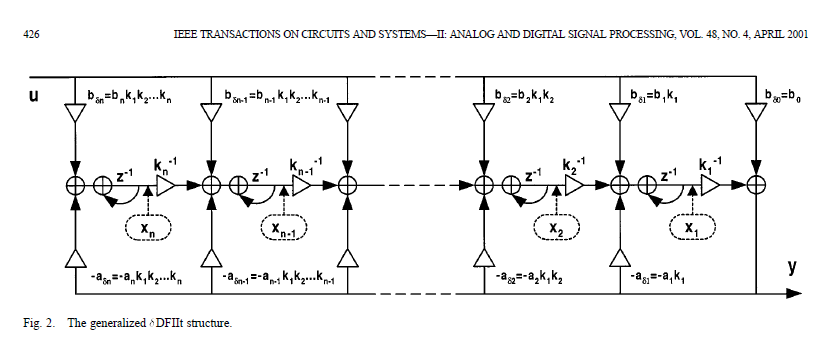

In [10]:
Image(filename='./Figures/dfiit.PNG')

The structure of the $\Sigma\Delta$ stream computation is based on a generalized direct-form delta operator-based IIR filter ($\delta$DFIIt). The $\delta$DFIIt is not just limited to filters but can also be used for state space realization of control applications. 

[A generalized direct-form delta operator-based IIR filter with minimum noise gain and sensitivity](https://ieeexplore.ieee.org/document/933811)

A similarity transform of the sampled time state space matrix is evaluated. This puts the $\delta$DFIIt structure into the observable canonical form, $T_{0}$. $T_{1}$ is first calculated as below.

$T_{1}=\left[\begin{array}{c}
C_{\delta}\\
C_{\delta}A_{\delta}\\
\vdots\\
C_{\delta}A_{\delta}^{n-1}
\end{array}\right]^{-1}\left[\begin{array}{c}
0\\
0\\
\vdots\\
1
\end{array}\right]$

In [11]:
e     = np.zeros((A.shape[1], 1))
e[-1] = 1

O = control.obsv(A, C)
[U, S, Vh] = linalg.svd(O)
V = Vh.T
S = np.diag(S)

S_inv = linalg.solve(S, np.eye(S.shape[0]))
T_inv = V @ S_inv @ U.conj().T
T1 = T_inv @ e;

The the observable canonical is now calculated

$T_{0}=\left[\begin{array}{ccccc}
A_{\delta}^{n-1}T_{1} & A_{\delta}^{n-2}T_{1} & \ldots & A_{\delta}T_{1} & T_{1}\end{array}\right]$

In [12]:
n  = A.shape[1]
T0 = np.zeros((n,n))

for i in range(1, n+1):
  column = np.linalg.matrix_power(A, n-i) @ T1
  T0[:, i-1] = column[:,0]

$T_{0}$ is now in the $\delta$DFIIt form. This similarity transformation produces the state space representation below

$\tilde{A_{\delta}}=T_{0}^{-1}A_{\delta}T_{0}$

$\tilde{B_{\delta}}=T_{0}^{-1}B_{\delta}$

$\tilde{C_{\delta}}=C_{\delta}T_{0}$

In [13]:
Ad_t = linalg.solve(T0, A @ T0)
Ad_t[:-1,1:] = np.eye(n-1)
Ad_t[-1,1:] = 0
Bd_t = linalg.solve(T0, B)
Cd_t = C @ T0;
Dd_t = D;

In [14]:
display(Latex(f'$%s$' % sdf.print_ss_eq(Ad_t,Bd_t,Cd_t,Dd_t)))

<IPython.core.display.Latex object>

$\tilde{H_{\delta}}(\delta)$ = $\tilde{D_{\delta}} + \tilde{C_{\delta}} \left(Is - \tilde{A_{\delta}}\right)^{-1} \tilde{B_{\delta}}$

The state space equation after structural transformation of filter into the $\delta$DFIIt form

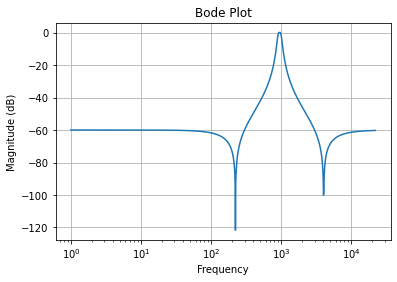

In [15]:
[mag, phz] = sdf.delta_bode(Ad_t,Bd_t,Cd_t,Dd_t,f,ts)
mag = np.squeeze(mag)
sdf.delta_bode_mag_plot(mag,f)

The state space model has been transformed but the underlying transfer function remains the same

## $\Sigma\Delta$ Transfer Function

The $\Sigma\Delta$ Transfer Function is used repeatedly in the following calculations to characterize the state space models over the frequency band of interest. The *delta_bode()* function is used to convert from continuous state space representation to the discrete $\delta$ based state space representation.

$\large \delta I = ((e^{\frac{-j\omega}{\Delta}} - 1) \times \frac{1}{\Delta})\times I$

$H(\delta)=\tilde{C_{\delta}}(\delta I-\tilde{A_{\delta}})\tilde{B_{\delta}}+D_{\delta}$

In [16]:
def delta_bode(A,B,C,D,f,ts):
  q     = C.shape[0]
  p     = B.shape[1]
  fs    = 1/ts
  mag   = np.zeros((q,p,f.shape[0]))
  phz   = np.zeros((q,p,f.shape[0]))
  delta = (np.exp(1j*2*np.pi*(f/fs))-1)/ts

  for i in range(f.shape[0]):
      A_d = delta[i] * np.eye(A.shape[0]) - A
      
      [A_d, T_d] = linalg.matrix_balance(A_d)
      B_d = linalg.solve(T_d, B)
      C_d = C @ T_d
      
      h   = linalg.solve(A_d, B_d)
      h   = (C_d @ h) + D
      mag[:,:,i] = np.abs(h)
      phz[:,:,i] = 180*np.arctan2(np.imag(h),np.real(h))/np.pi
  return mag, phz

## Dynamic Range Scaling of State Variable Integrators

The internal integrators must be scaled appropriately to maximize the SNR at each node. A scaling matrix $T_{s}$  scales the coefficients $k_{1}$ to $k_{N}$ located after the $\delta^{-1}$ operators (integrators).

$T_{s}=diag\left[k_{1}^{-1},\left(k_{1}k_{2}\right)^{-1},\ldots,\left(k_{1}k_{2}\ldots k_{n}\right)^{-1}\right]$

The state space equations are then transformed

$\tilde{A_{\delta}^{'}}=T_{s}^{-1}T_{0}^{-1}A_{\delta}T_{0}T_{s}$

$\tilde{B_{\delta}^{'}}=T_{s}^{-1}T_{0}^{-1}B_{\delta}$

$\tilde{C_{\delta}^{'}}=C_{\delta}T_{0}T_{s}$

$H(\delta)=\tilde{C_{\delta}^{'}}(\delta I-\tilde{A_{\delta}^{'}})\tilde{B_{\delta}^{'}}+D_{\delta}$

Transfer functions from the input to the ith state integrator

$f_{i}\left(\delta\right)=\frac{x_{i}\left(\delta\right)}{u\left(\delta\right)}$ = $T_{s}^{-1}T_{0}^{-1}\left(\delta I-A_{\delta}\right)^{-1}B_{\delta}$

In [17]:
T0_inv = linalg.solve(T0, np.eye(T0.shape[0]))
[f_i, phz] = sdf.delta_bode(Ad,Bd,T0_inv,0,f,ts)

The internal gain of the filter structure is calculated with the $\infty$-norm for discrete $\delta$ based filters to normalize each integrator node. The scaling coefficients in $T_{s}$ are then be found using back substitution.

$\left\Vert H(\frac{e^{j\omega}-1}{\Delta})\right\Vert _{p}=\left[\frac{1}{2\pi}\intop_{-\pi}^{\pi}|H\left(\frac{e^{j\omega}-1}{\Delta}\right)|^{p}d\omega\right]^{1/p}$

$||f(\delta)||_{\infty}	=T_{s}^{-1}||T_{0}^{-1}\left(\delta I-A_{\delta}\right)^{-1}B_{\delta}||_{\infty}
	=\left[\begin{array}{ccc}
1 & \cdots & 1\end{array}\right]^{T}$

In [18]:
f_norm = np.zeros(Ad.shape[0])

for i in range(f_norm.shape[0]):
  f_norm[i] = linalg.norm(f_i[i], np.inf, axis=1)

Ts = np.zeros(Ad.shape)
k = np.zeros(f_norm.shape[0])
k_inv = np.zeros(f_norm.shape[0])

for i in range(f_norm.shape[0]):
  if i == 0:
    k[i] = 1/f_norm[i]
  else:
    k[i] = 1/(np.prod(k[:i])*f_norm[i])

  k_inv[i] = 2**np.floor(np.log2(ts/k[i]))/ts
  Ts[i,i] = np.prod(k_inv[0:i+1])

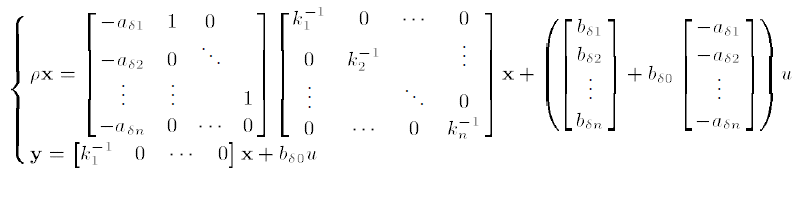

In [19]:
Image(filename='./Figures/dfiit_ss.PNG')

This illustrates the state space difference equations for the $\delta$DFIIt filter

1023


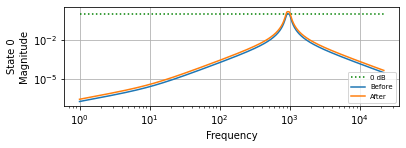

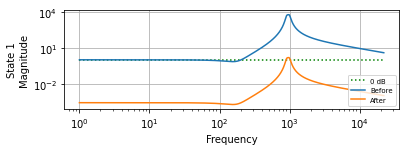

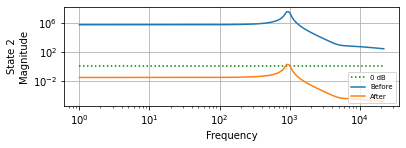

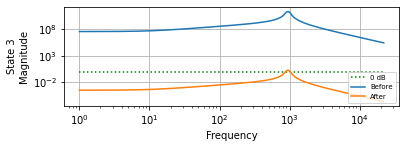

In [20]:
[f_i_after, phz] = sdf.delta_bode(Ad,Bd,linalg.inv(Ts) @ T0_inv,0,f,ts)
before = np.squeeze(f_i)
after  = np.squeeze(f_i_after )
print(f.shape[0]-1)
sdf.mag_before_after_plot(before,after,f,'State', legend=['0 dB','Before','After'], add_line=1)

These plots below show each state node's transition to being normalized to 0 dB, the dotted green line

$\Sigma\Delta$ stream computation modifies the $\delta$DFIIt form by implementing the scaling coefficients as bit shift rather than multiplication. Adjusting the scaling coefficients to be a power of two multiply/divide reduces the filter architecture complexity.

$\tilde{k}_{i}=\frac{2^{\left\lfloor log_{2}\Delta\cdot k_{i}^{-1}\right\rfloor }}{\Delta}$

In [25]:
k_inv = np.diag(k_inv)
[num_t, den_t] = signal.ss2tf(Ad_t,Bd_t,Cd_t,Dd_t)
num_ts = num_t.copy()
num_ts[0,1:] /= np.diag(Ts).T
den_ts = den_t.copy()
den_ts[1:] /= np.diag(Ts).T
den_ts[0] = 1

beta  = num_ts[0]
alpha = den_ts
k_ts  = k * ts
k_ts  = np.append(k_ts, 0)
shift = np.round(np.abs(np.log2(ts*k)))
shift = np.append(shift, 0)

s = '''
### $\\alpha_{i}$ and $\\beta_{i}$ Coefficients
|$i$|$\\alpha_{i}$| $\\beta_{i}$|$\\Delta\\tilde{k}_{n-1}^{-1}$|Right Shift|
|----------------|----------------|----------------|----------------|----------------|
'''

for i in range(beta.shape[0]):
  s += '| '  + str(i)
  s += '| '  + str(alpha[i])
  s += '| '  + str(beta[i])
  s += '| '  + str(k_ts[i])
  s += '| '  + str(int(shift[i])) + '|\n'

display(Markdown(s))


### $\alpha_{i}$ and $\beta_{i}$ Coefficients
|$i$|$\alpha_{i}$| $\beta_{i}$|$\Delta\tilde{k}_{n-1}^{-1}$|Right Shift|
|----------------|----------------|----------------|----------------|----------------|
| 0| 1.0| 0.0010000000000000009| 8.866572012319641e-08| 23|
| 1| 1593.667490385439| 3.378948116518743e-13| 1.4417410160254718e-11| 36|
| 2| 19312.059697242676| 174.3276889642899| 1.4539965148863326e-11| 36|
| 3| 1863.3856843478065| -1.1193230949549415e-12| 1.5418270884441147e-11| 36|
| 4| 11199.535895346933| 11.199535895338775| 0.0| 0|




 The floating point simulation will take several minutes to run.


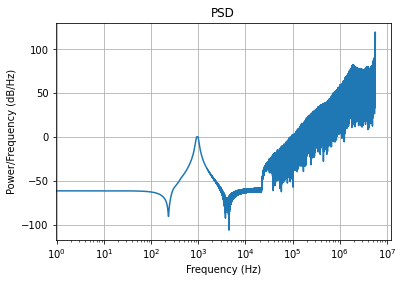

In [22]:
filter = sdf.sd_filter(OSR,fb)
filter.run(A,B,C,D)
sd_sim.sim_filter(filter)

The power spectral density from a pyhon floating point simulation with the previously calculated $\alpha_{i}$ and $\beta_{i}$ coefficients.

In [23]:
the_delta_filter = [Ad,Bd,Cd,Dd,k,k_inv,T0,Ts,f,ts,alpha,beta]
%store the_delta_filter

Stored 'the_delta_filter' (list)


Goto the next step - [Coefficient Sensitivity Analysis](./3_SD_dIIR_sensitivity.ipynb)